# Camera calibration

In [2]:
##Camera Calibration
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
#import os

save_dir= r'output_images/chess/'

#Prepare object points (0,0,0),(1,0,0),(2,0,0) ....,(8,4,0)
objp = np.zeros((9*6,3), np.float32)
#print(objp)
objp[:,:2]= np.mgrid[0:9,0:6].T.reshape(-1,2)
#print(objp)

objpoints=[] #3d points in real world
imgpoints=[] #2d points in image

#Images to calibrate from
img_files = glob.glob('camera_cal/*.jpg')
#print(img_files)
"""
[X] Find chessboard corners
[X] Add image points, object points
[X] Display corners
[X] Camera calibration
"""

for file in img_files:
    #Get file sufix
    sufix=file[22:]
    #print("Opening file: "+sufix)
    img=cv2.imread(file)
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    #If corners exist
    if ret == True:
        print(sufix+" Corners Found!")
        objpoints.append(objp)
        imgpoints.append(corners)
        
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        file_name= save_dir + 'chess_corners' + sufix
        #print(file_name)
        print("Saving Image...")
        cv2.imwrite(file_name, img)
    else:
        print("No corners found on {}!".format(sufix))
    
img_size=(img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

camCal_pickle={"mtx": mtx,
              "dist": dist,
              "rvecs": rvecs,
              "tvecs": tvecs}
pickle.dump(camCal_pickle, open ('CamCal/camCal_pickle.p', "wb") )
print("Pickle Saved")

No corners found on 1.jpg!
10.jpg Corners Found!
Saving Image...
11.jpg Corners Found!
Saving Image...
12.jpg Corners Found!
Saving Image...
13.jpg Corners Found!
Saving Image...
14.jpg Corners Found!
Saving Image...
15.jpg Corners Found!
Saving Image...
16.jpg Corners Found!
Saving Image...
17.jpg Corners Found!
Saving Image...
18.jpg Corners Found!
Saving Image...
19.jpg Corners Found!
Saving Image...
2.jpg Corners Found!
Saving Image...
20.jpg Corners Found!
Saving Image...
3.jpg Corners Found!
Saving Image...
No corners found on 4.jpg!
No corners found on 5.jpg!
6.jpg Corners Found!
Saving Image...
7.jpg Corners Found!
Saving Image...
8.jpg Corners Found!
Saving Image...
9.jpg Corners Found!
Saving Image...
Pickle Saved


# Distortion Correction
Uses previously calibrated camera and params

In [3]:
## Distortion correction

Cam_Calib=pickle.load( open("CamCal/camCal_pickle.p", "rb"))

cam_dist=Cam_Calib["dist"]
cam_mtx=Cam_Calib["mtx"]
img_files = glob.glob('test_images/*.jpg')
save_dir= r'output_images/undist/'

for file in img_files:
    img= cv2.imread(file)
    sufix=file[12:]
    dst=cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)
    cv2.imwrite(save_dir+sufix[:-4]+"_undist.jpg", dst)
    
    


# Image preprocessing (Gradient threshold)

In [203]:
#Gradient Threshold
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

up_kernel = [[-1.,-1.,2.],
         [-1.,2.,-1.],
         [2.,-1.,-1.]]
up_kernel=np.asarray(up_kernel)/12.0


down_kernel = [[2.,-1.,-1.],
         [-1.,2.,-1.],
         [-1.,-1.,2.]]
down_kernel=np.asarray(down_kernel)/12.0


def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    """Orientation threshold, asumes img is gray image"""
    # 2) Take the gradient in x and y separately
    sobel_x=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_x=np.abs(sobel_x)
    abs_y=np.abs(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    orient_sobel=np.arctan2(abs_y,abs_x)
    # 5) Create a binary mask where direction thresholds are met
    binary_output=np.zeros_like(orient_sobel)
    # 6) Return this mask as your binary_output image
    binary_output[(orient_sobel>thresh[0])&(orient_sobel<thresh[1])]=1 # Remove this line
    return binary_output

def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255, sobel_kernel=3):
    """Axis sobel, asumes img is gray image"""
    # Apply the following steps to img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    elif orient=='+':
        sobel = cv2.filter2D(gray,-1,up_kernel)
    elif orient=='-':
        sobel = cv2.filter2D(gray,-1,down_kernel)
    else:
        raise "Not valid orientation!"
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel=np.uint8(255 * abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output=np.zeros_like(scaled_sobel)
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel>thresh_min) & (scaled_sobel<thresh_max)] = 1
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    """Magnitude, asumes img is gray image"""
    # 2) Take the gradient in x and y separately
    sobel_x=cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y=cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel=np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_sobel=np.uint8(abs_sobel*255/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(scale_sobel)
    binary_output[(scale_sobel>mag_thresh[0])&(scale_sobel<mag_thresh[1])]=1
    # 6) Return this mask as your binary_output image
    return binary_output

<function __main__.test_hls_tresh>

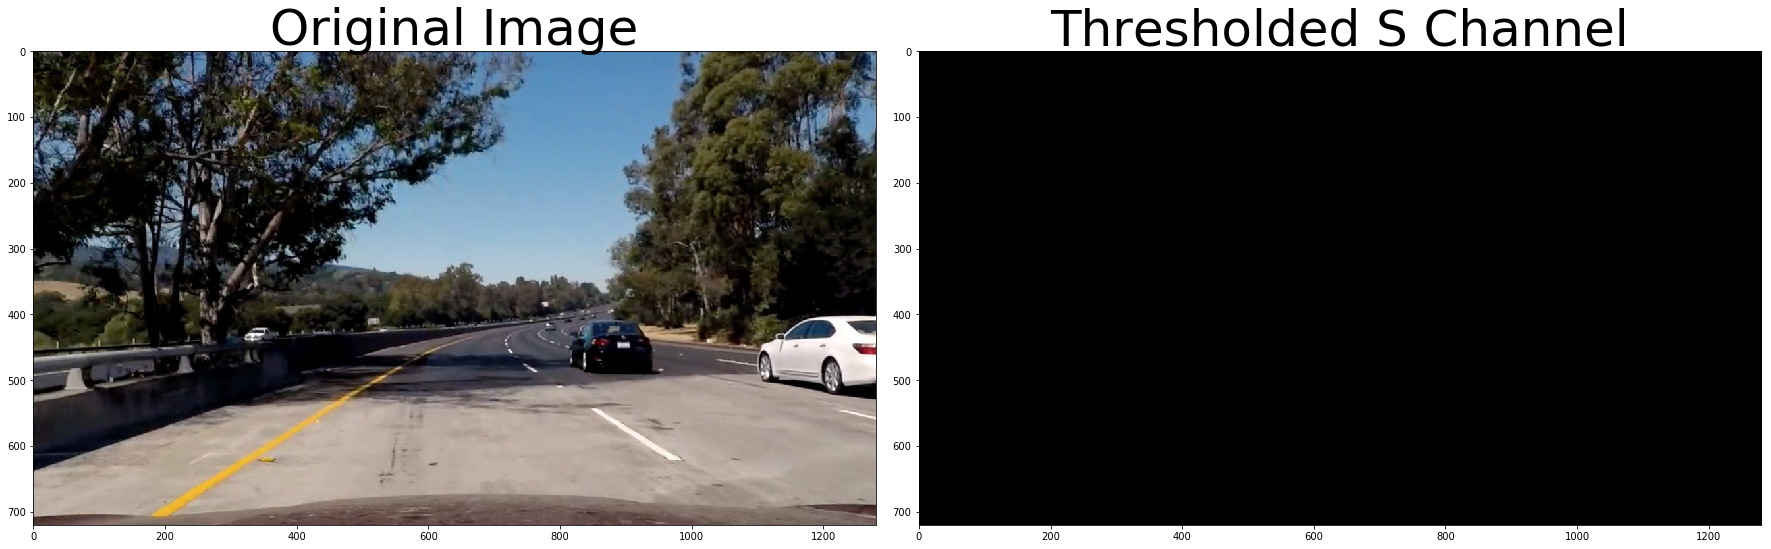

In [278]:
def multiple_threshold(kernel, min_gradx, max_gradx, min_grady, max_grady, min_mag, max_mag, min_or, max_or):
    # Apply the following steps to img
    # 1) Apply sobel in direction
    gradx=abs_sobel_thresh(image, orient='x', thresh_min=min_gradx, thresh_max=max_gradx, sobel_kernel=kernel)
    grady=abs_sobel_thresh(image, orient='y', thresh_min=min_grady, thresh_max=max_grady, sobel_kernel=kernel)
    binary_dir=np.zeros_like(gradx)
    binary_dir[(gradx==1)&(grady==1)]=1
    # 2)Apply sobel Magnitude
    bin_mag=mag_thresh(image, sobel_kernel=kernel, mag_thresh=(min_mag,max_mag))

    # 3)Apply sobel orientation
    # 4)Mix all above
    
    
    binary_output=np.zeros_like(gradx)
    binary_output[(binary_dir==1)|bin_mag==1]=1
    #binary_output[(orient_sobel>min_or)&(orient_sobel<max_or)]=1 # Remove this line
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(binary_output, cmap='gray')
    ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
color_image=mpimg.imread("output_images/undist/test5_undist.jpg")
image=cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)
image=cv2.blur(image,(7,7))

%matplotlib inline

HLS_img=cv2.cvtColor(color_image, cv2.COLOR_RGB2HLS)
S_channel= HLS_img[:,:,2]
def test_hls_tresh(low_limit=0, high_limit=255):
    s_binary=np.zeros_like(S_channel)
    s_binary[(S_channel>=low_limit) & (S_channel<=high_limit)]=1
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(color_image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(s_binary, cmap='gray')
    #ax2.imshow(S_channel, cmap='gray')
    ax2.set_title('Thresholded S Channel', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

from ipywidgets import *
interact(test_hls_tresh, low_limit=(0,255), high_limit=(0,255))

# Experiment Below!

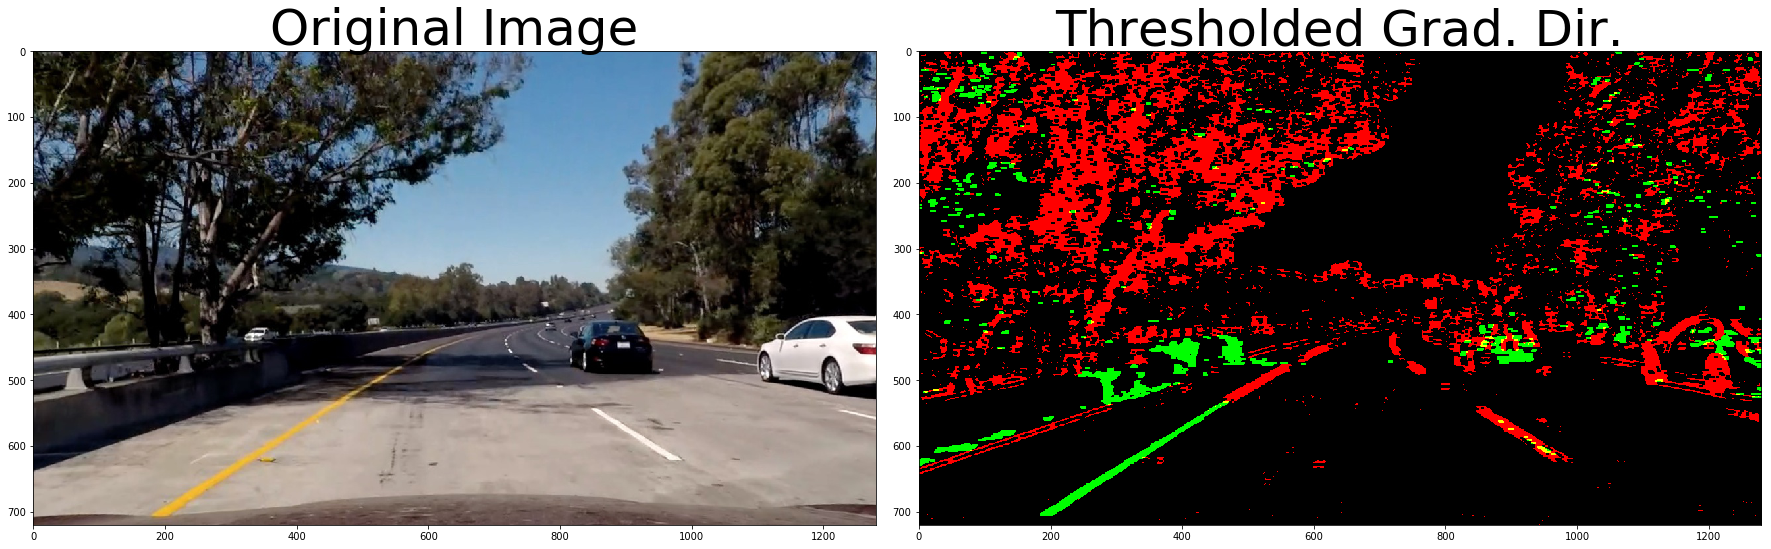

In [279]:
from ipywidgets import *

def hls_tresh(low_limit=0, high_limit=255):
    s_binary=np.zeros_like(S_channel)
    s_binary[(S_channel>=low_limit) & (S_channel<=high_limit)]=1
    return s_binary

def test_multiple_threshold(kernel, min_gradx, max_gradx, min_dt, max_dt, min_mag, max_mag, min_or, max_or, s_low, s_high ):
    # Apply the following steps to img
    # 1) Apply sobel in direction
    gradx=abs_sobel_thresh(image, orient='x', thresh_min=min_gradx, thresh_max=max_gradx, sobel_kernel=kernel)
    #Less significant on Y axis , lots of noise
    #grady=abs_sobel_thresh(image, orient='y', thresh_min=min_grady, thresh_max=max_grady, sobel_kernel=kernel)
    binary_dir=np.zeros_like(gradx)
    #binary_dir[(gradx==1)|(grady==1)]=1
    
    #Diagonal Sobels!
    pos=abs_sobel_thresh(image, orient='+', thresh_min=min_dt, thresh_max=max_dt)
    neg=abs_sobel_thresh(image, orient='-', thresh_min=min_mag, thresh_max=max_mag)
    bin_diag=np.zeros_like(pos)
    bin_diag[(pos==1)|(neg==1)]=1
    bin_diag=cv2.morphologyEx(bin_diag, cv2.MORPH_CLOSE, np.ones((3,5),np.uint8))
    
    # 2)Apply sobel Magnitude
    #Even smaller magnitudes cause noise
    #bin_mag=mag_thresh(image, sobel_kernel=kernel, mag_thresh=(min_mag,max_mag))
    # 3)Apply sobel orientation
    #Lots of noise (even when combining magnitud and orientation)
    bin_or=dir_threshold(image, sobel_kernel=kernel, thresh=(min_or, max_or))
    #binary_dir[(bin_mag==1)&(bin_or==1)]=1
    # 4) Saturation channel
    s_bin= hls_tresh(low_limit=s_low, high_limit=s_high)
    s_bin=cv2.morphologyEx(s_bin, cv2.MORPH_OPEN, np.ones((3,7),np.uint8))
    
    # 5)Mix all above
    
    binary_output=np.zeros_like(gradx)
    binary_output[((bin_diag==1)|(s_bin==1))]=1
    """
    print(binary_dir.shape)
    print(bin_mag.shape)
    print(bin_or.shape)
    print(s_bin.shape)
    """
    tricolor_output=np.dstack((bin_diag, s_bin, bin_or))
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(color_image)
    ax1.set_title('Original Image', fontsize=50)
    #ax2.imshow(binary_output, cmap='gray')
    ax2.imshow(tricolor_output)
    ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

"""    
multiple_threshold(kernel=3, min_gradx=0, max_gradx=255,
                   min_grady=0, max_grady=255,min_mag=0,
                   max_mag=255, min_or=0, max_or=np.pi/2)
"""
interact(test_multiple_threshold, kernel=(1,31,2),
         min_gradx=(0,255), max_gradx=(0,255),
         min_dt=(0,255), max_dt=(0,255),
         min_mag=(0,64), max_mag=(0,255),
         min_or=(0, np.pi/2, np.pi/30), max_or=(0, np.pi/2, np.pi/30),
        s_low=(0,255), s_high=(0,255))

# Final Pipeline

Excecution time: 0.04200243949890137


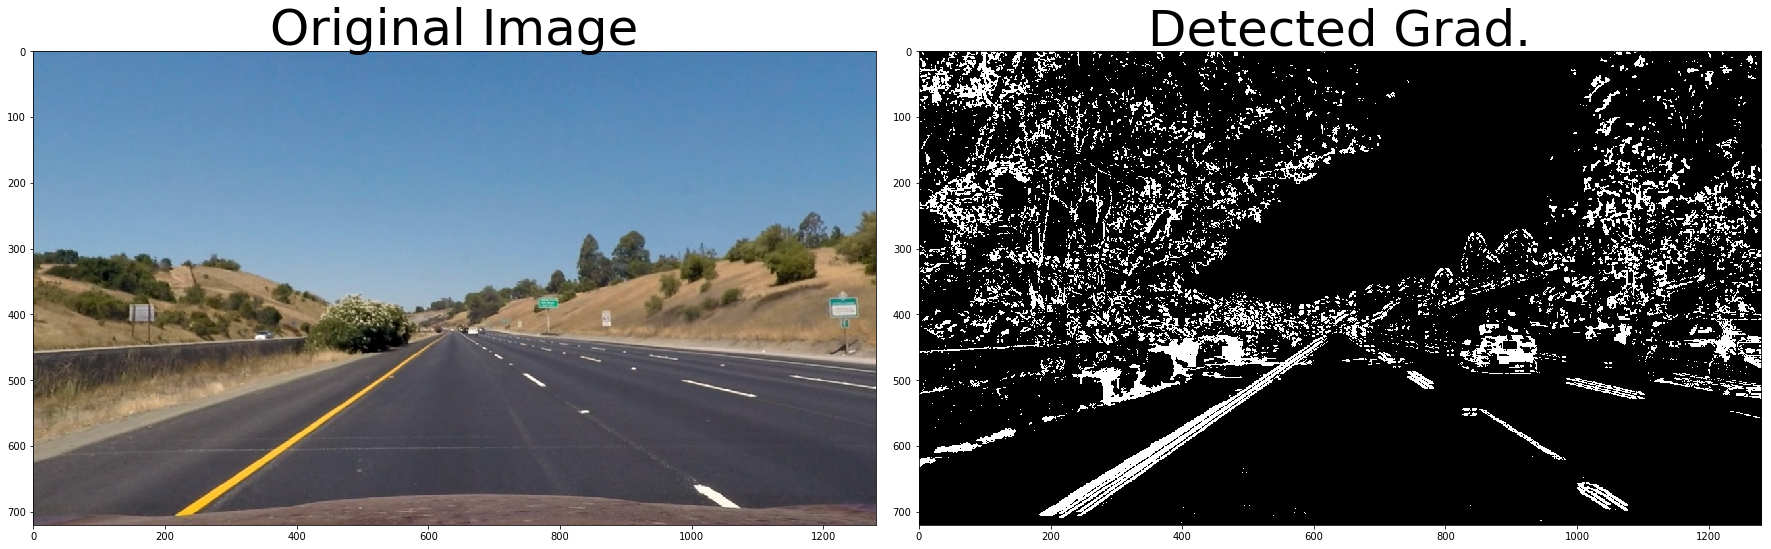

In [291]:
import time
def multiple_threshold(image, min_dt=0, max_dt=255, s_low=150, s_high=255, k_slope1=up_kernel, k_slope2=down_kernel):
    # Apply the following steps to img
    # 1) Apply sobel in direction
    #X not used, noisy
    #Less significant on Y axis , lots of noise
    #Diagonal Sobels!
    pos=abs_sobel_thresh(image, orient='+', thresh_min=min_dt, thresh_max=max_dt)
    neg=abs_sobel_thresh(image, orient='-', thresh_min=min_dt, thresh_max=max_dt)
    bin_diag=np.zeros_like(pos)
    bin_diag[(pos==1)|(neg==1)]=1
    #Close gaps in binary image
    
    #bin_diag=cv2.morphologyEx(bin_diag, cv2.MORPH_CLOSE, np.ones((3,5),np.uint8))
    
    # 2)Apply sobel Magnitude
    #Even smaller magnitudes cause noise, not using
    # 3)Apply sobel orientation
    #Lots of noise (even when combining magnitude and orientation)
    # 4) Saturation channel
    s_bin= hls_tresh(low_limit=s_low, high_limit=s_high)
    #Open big spaces, as to desaturate the saturated channel (bad_joke_here)
    
    #s_bin=cv2.morphologyEx(s_bin, cv2.MORPH_OPEN, np.ones((3,7),np.uint8))
    
    # 5)Mix all above
    #Only 2 at the end
    binary_output=np.zeros_like(bin_diag)
    binary_output[((bin_diag==1)|(s_bin==1))]=1
    return binary_output
 
color_image=mpimg.imread("output_images/undist/straight_lines1_undist.jpg")
image=cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)
image=cv2.blur(image,(7,7))

start=time.time()
detect= multiple_threshold(image)
print ("Excecution time: {}".format(time.time()-start))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(detect, cmap='gray')
ax2.set_title('Detected Grad.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    